# Web Scraping using Python
There many libraries in Python could help us crawl data from website easily. It could be simple as *requests*, *urllib*, *pandas.read_html* or more complex like *Selenium*.
## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
import time
import os
from fuzzywuzzy import fuzz
from matplotlib import pyplot as plt
import seaborn as sns

## 2. Web scraping
### 2.1. Deal with login page
With simple login page, we could use popular Python library such as *mechanize*. If webpage become more complicated, we should consider using *Selenium* for convenience.

In [ ]:
import mechanize

url = 'url'

br = mechanize.Browser()
br.open(url)

br.select_form(id='form1')
br.form['txtUser'] = 'demo'
br.form['txtPass'] = 'DeMo@123456'
br.submit()

print(br.response().read())

soup = BeautifulSoup(br.response().read())
soup # act as normally

### 2.2. Using *requests* library
Note that we can use both *requests* library and *urlopen*. The results will be the same but *requests* seem to be faster.

In [3]:
url = 'http://www.hubertiming.com/results/2017GPTR10K'
html = requests.get(url)
soup = BeautifulSoup(html.text, 'html.parser')

# Get the title
title = soup.title
print(title)

text = soup.get_text() # or print(soup.text)

<title>2017 Intel Great Place to Run 10K \ Urban Clash Games Race Results</title>


There are some useful method helping scraping process much faster:
1. *find_all* method to extract useful html tags within a webpage. 
2. Tags include <*a*> for hyperlinks, <*table*> for tables, <*tr*> for table rows, <*th*> for table headers, and <*td*> for table cells.

The following cell is used for working with table.

In [4]:
all_links = soup.find_all("a")
for link in all_links:
    print(link.get("href"))
    
# Table rows    
rows = soup.find_all('tr')
# Data from table cells
list_rows = []
for row in rows:
    row_td = row.find_all('td')
    print(row_td)

# Clean html tags using beautifulsoup. Using regex is not recommended
    str_cells = str(row_td)
    cleantext = BeautifulSoup(str_cells, "lxml").get_text()
    list_rows.append(cleantext)
    
print(cleantext)
type(cleantext)

mailto:timing@hubertiming.com
https://www.hubertiming.com/
#individual
#team
/results/2017GPTR
/results/summary/2017GPTR10K
#tabs-1
None
None
https://www.hubertiming.com/
https://facebook.com/hubertiming/
[]
[<td>Finishers:</td>, <td>577</td>]
[<td>Male:</td>, <td>414</td>]
[<td>Female:</td>, <td>163</td>]
[]
[<td>1</td>, <td>814</td>, <td>JARED WILSON</td>, <td>M</td>, <td>TIGARD</td>, <td>OR</td>, <td>36:21</td>, <td>5:51</td>, <td>1 of 414</td>, <td>M 36-45</td>, <td>1 of 152</td>, <td>0:03</td>, <td>36:24</td>, <td></td>]
[<td>2</td>, <td>573</td>, <td>NATHAN A SUSTERSIC</td>, <td>M</td>, <td>PORTLAND</td>, <td>OR</td>, <td>36:42</td>, <td>5:55</td>, <td>2 of 414</td>, <td>M 26-35</td>, <td>1 of 154</td>, <td>0:03</td>, <td>36:45</td>, <td>INTEL TEAM F</td>]
[<td>3</td>, <td>687</td>, <td>FRANCISCO MAYA</td>, <td>M</td>, <td>PORTLAND</td>, <td>OR</td>, <td>37:44</td>, <td>6:05</td>, <td>3 of 414</td>, <td>M 46-55</td>, <td>1 of 64</td>, <td>0:04</td>, <td>37:48</td>, <td></td>]
[<t

str

Recommend to use **BeautifulSoup** library to deal with html tags. Using **regex** should be avoided. Below is an example of using **regex**.

In [5]:
import re

list_rows = []
for row in rows:
    cells = row.find_all('td')
    str_cells = str(cells)
    clean = re.compile('<.*?>')
    clean2 = (re.sub(clean, '',str_cells))
    list_rows.append(clean2)
print(clean2)
type(clean2)

[14TH, INTEL TEAM M, 04:43:23, 00:58:59 - DANIELLE CASILLAS, 01:02:06 - RAMYA MERUVA, 01:17:06 - PALLAVI J SHINDE, 01:25:11 - NALINI MURARI]


str

## 3. Put data into DataFrame for preprocessing and analysing

In [6]:
# Convert to dataframe and find datatype
df = pd.DataFrame(list_rows)
df.head(10)

# Split using str.split() method
df1 = df[0].str.split(',', expand=True)
df1.head(10)

# Remove unwanted square brackets
df1[0] = df1[0].str.strip('[')
df1.head(10)

# Find all table headers
col_labels = soup.find_all('th')
all_header = []
col_str = str(col_labels)
cleantext2 = BeautifulSoup(col_str, "lxml").get_text()
all_header.append(cleantext2)
print(all_header)

# And put in a dataFrame & cleaning
df2 = pd.DataFrame(all_header)
df2.head()

df3 = df2[0].str.split(',', expand=True)
df3.head()

# Concatenate two dataframes
df4 = pd.concat([df3, df1])
df4.head(10)

# Rename 1st row tobe table header
df5 = df4.rename(columns=df4.iloc[0])
df5.head()

# Some information about df5
df5.info()
df5.shape

# Drop missing value
df6 = df5.dropna(axis=0, how='any')

# Drop duplicate at the index
df7 = df6.drop(df6.index[0])
df7.head()

# Rename column
df7.rename(columns={'[Place': 'Place'},inplace=True)
df7.rename(columns={' Team]': 'Team'},inplace=True)
df7.head()

# Strip closing square bracket
df7['Team'] = df7['Team'].str.strip(']')
df7.head()

['[Place, Bib, Name, Gender, City, State, Chip Time, Chip Pace, Gender Place, Age Group, Age Group Place, Time to Start, Gun Time, Team]']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 598 entries, 0 to 596
Data columns (total 14 columns):
[Place              598 non-null object
 Bib                596 non-null object
 Name               593 non-null object
 Gender             593 non-null object
 City               593 non-null object
 State              593 non-null object
 Chip Time          593 non-null object
 Chip Pace          578 non-null object
 Gender Place       578 non-null object
 Age Group          578 non-null object
 Age Group Place    578 non-null object
 Time to Start      578 non-null object
 Gun Time           578 non-null object
 Team]              578 non-null object
dtypes: object(14)
memory usage: 70.1+ KB


,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team
5,1,814,JARED WILSON,M,TIGARD,OR,36:21,5:51,1 of 414,M 36-45,1 of 152,0:03,36:24,
6,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,36:42,5:55,2 of 414,M 26-35,1 of 154,0:03,36:45,INTEL TEAM F
7,3,687,FRANCISCO MAYA,M,PORTLAND,OR,37:44,6:05,3 of 414,M 46-55,1 of 64,0:04,37:48,
8,4,623,PAUL MORROW,M,BEAVERTON,OR,38:34,6:13,4 of 414,M 36-45,2 of 152,0:03,38:37,
9,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,39:21,6:20,5 of 414,M 26-35,2 of 154,0:03,39:24,INTEL TEAM F


## 4. Data visualization

In [7]:
# Convert time to mins only - normalization
time_list = df7[' Chip Time'].tolist()
time_mins = []
for i in time_list:
    sp = i.split(':')
    if len(sp) == 2:
        m, s = i.split(':')
        h = 0
    elif len(sp) == 3:
        h, m, s = i.split(':')
    math = (int(h) * 3600 + int(m) * 60 + int(s))/60
    time_mins.append(math)
df7['Runner_mins'] = time_mins

A boxplot is useful tool to visualize summary statistics (such as describe()). For data visualization, it is convenient to first import parameters from the pylab module that comes with matplotlib and set the same size for all figures to avoid doing it for each figure.

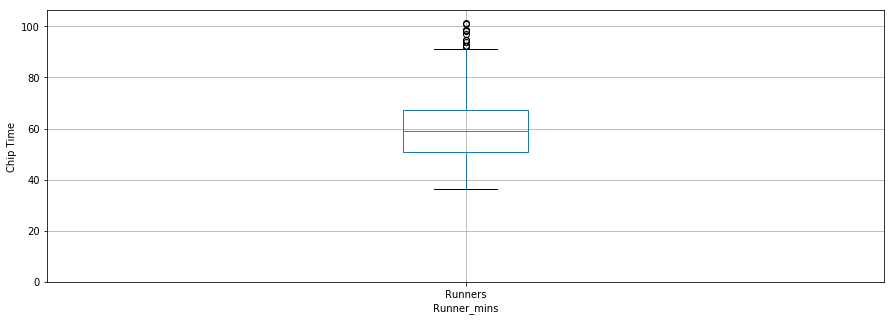

        Runner_mins                                                         \
              count       mean        std        min        25%        50%   
 Gender                                                                      
 F            163.0  66.119223  12.184440  43.766667  58.758333  64.616667   
 M            414.0  57.640821  11.011857  36.350000  49.395833  55.791667   

                                
               75%         max  
 Gender                         
 F       72.058333  101.300000  
 M       64.804167   98.516667  


/home/manhnh/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, '')

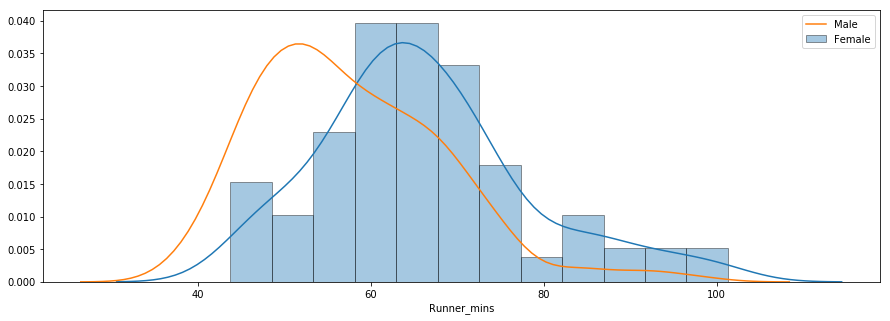

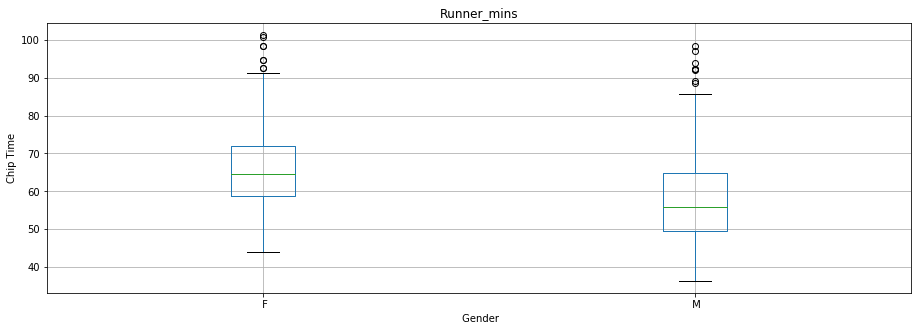

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

df7.boxplot(column='Runner_mins')
plt.grid(True, axis='y')
plt.ylabel('Chip Time')
plt.xticks([1], ['Runners'])

# Distribution of running time (normal distribution or not)
x = df7['Runner_mins']
ax = sns.distplot(x, hist=True, kde=True, rug=False, color='m', bins=25, hist_kws={'edgecolor':'black'})
plt.show()

# Compare male vs female performance
f_fuko = df7.loc[df7[' Gender']==' F']['Runner_mins']
m_fuko = df7.loc[df7[' Gender']==' M']['Runner_mins']
sns.distplot(f_fuko, hist=True, kde=True, rug=False, hist_kws={'edgecolor':'black'}, label='Female')
sns.distplot(m_fuko, hist=False, kde=True, rug=False, hist_kws={'edgecolor':'black'}, label='Male')
plt.legend()

# Or compute statistic summary as this method
g_stats = df7.groupby(" Gender", as_index=True).describe()
print(g_stats)

# side-by-side boxplot comparison 
df7.boxplot(column='Runner_mins', by=' Gender')
plt.ylabel('Chip Time')
plt.suptitle("")

## 5. Apply to real problem
Finally, I apply web scraping to crawl data that related to my hometown, Dong Anh district (Hanoi) from newspaper.

### 5.1. Label translation
The following *dict* represent label translation.

In [2]:
field_dict = {
    'su-kien': 'Sự kiện',
    'xa-hoi': 'Xã hội',
    'the-gioi': 'Thế giới',
    'the-thao': 'Thể thao',
    'thoi-su': 'Thời sự',
    'giao-duc-khuyen-hoc': 'Giáo dục',
    'giao-duc': 'Giáo dục',
    'tam-long-nhan-ai': 'Nhân ái',
    'kinh-doanh': 'Kinh doanh',
    'bat-dong-san': 'Bất động sản',
    'van-hoa': 'Văn hóa',
    'giai-tri': 'Giải trí',
    'phap-luat': 'Pháp luật',
    'nhip-song-tre': 'Nhịp sống trẻ',
    'suc-khoe': 'Sức khỏe',
    'suc-manh-so': 'Sức mạnh số',
    'o-to-xe-may': 'Xe++',
    'tinh-yeu': 'Tình yêu giới tính'
}

### 5.2. Crawling data
Start crawling data!

In [3]:
n = 20 # number of pages to crawl: ~ 1.000 data points
l1, ldf, t = [], 0, 0 # list and len of data frames
for k in range(n):
    t1 = time.time()
    if k == 0:
        url = 'https://dantri.com.vn/dong-anh.tag'
        print('Start crawling')
    else:
        url = 'https://dantri.com.vn/dong-anh/trang-' + str(k) + '.tag'
    
    l2 = [] # list of dataframe

    # Connect to url
    r = requests.get(url)
    s = BeautifulSoup(r.text, "html.parser")
    for i in range(20):
        # Locate 'a' tag and find link through 'href' key
        temp = s.findAll('a')
        if len(temp) < 47+3*i:
            break
        link = temp[47+3*i]['href'] # link in a page

        # Get the field from the link
        if link.count('/') != 2:
            continue
        field_ = link.split('/')[1]
        if field_ not in field_dict:
            continue
        field = field_dict[field_]

        # Request sub-url
        new_req = requests.get('https://dantri.com.vn' + link)
        new_soup = BeautifulSoup(new_req.text, 'html.parser')
        text_ = new_soup.get_text()

        # Extract useful information only
        key_ = '\n\n\n\n' + field + '\xa0\xa0›\xa0\xa0\r\n'
        ind1 = text_.find(key_)
        ind2 = text_.find('\n\n\n\n\n\n\r\n                            .fullScreen')
        new_text = text_[ind1 + len(key_):ind2].replace('\r\n                        \n\n\r\n        Chia sẻ', '.')

        # Divide into two parts through finding proper index
        ind5 = new_text.find('>>')
        ind6 = new_text.find('/*ims gan*/')
        ind7 = new_text.find('}\r\n                        \n\n')
        if ind7 != -1:
            if ind5 != -1:
                text = new_text[:ind5] + new_text[ind7 + 28:]
            else:
                text = new_text[:ind6] + new_text[ind7 + 28:]

        # Split into different parts
        ind8 = text.find('\r\n                                \n')
        ind9 = text[::-1].find('.')
        part1 = re.sub(' +', ' ', text[:ind8].replace('\n', ' ').replace('\r', ' '))[1:] # Time + Title + Abstract
        part2 = re.sub(' +', ' ', text[ind8 + 35:-ind9].replace('\n', ' ').replace('\r', ' ')) # Content
        part3 = text[-ind9:] # Name of Writer and Tag

        # Building data frame from dict
        keys = ['Field', 'Time', 'Title', 'Abstract', 'Content', 'Writer', 'Tag']
        dict_ = {key: [] for key in keys}

        dict_['Field'].append(field)
        p1 = part1.split('.')[0]
        match = re.search(r'\d{2}/\d{2}/\d{4}', p1)
        if match == None:
            dict_['Time'].append(np.nan)
            dict_['Title'].append(p1)
        else:
            dict_['Time'].append(match.group()) 
            ind = p1.find(match.group())
            dict_['Title'].append(p1[ind + 19:])

        dict_['Abstract'].append('.'.join(part1.split('.')[1:]))
        dict_['Content'].append(part2)

        p2 = part3.split('Tag')
        dict_['Writer'].append(p2[0].replace('\n', ''))
        if len(p2) >= 2 and len(p2[1].split('\n')) > 2:
            dict_['Tag'].append(tuple(p2[1].split('\n')[2:]))
        else:
            dict_['Tag'].append(np.nan)
    
        l2.append(pd.DataFrame.from_dict(dict_))
        time.sleep(1)
    
    temp_l = []
    if len(l2) >= 2:
        temp_l = pd.concat(l2)
    elif len(l2) == 1:
        temp_l = l2[0]
    elif l2 == []:
        continue
    ldf += len(temp_l)
    t += time.time() - t1
    l1.append(temp_l)
    
    if (k+1)%5 == 0:
        print('Crawled page number {}, length of df: {}, spent time = {}'.format(k+1, ldf, np.around(t, decimals=0)))
    time.sleep(3)
    
df = pd.concat(l1, ignore_index=True)
# Save to file
df.to_json('dantri.json', orient='records', lines=True, force_ascii=False)
display(df.head())
print(df.shape)

Start crawling
Crawled page number 5, length of df: 82, spent time = 105.0
Crawled page number 10, length of df: 166, spent time = 226.0
Crawled page number 15, length of df: 245, spent time = 316.0


,Field,Time,Title,Abstract,Content,Writer,Tag
0,Bất động sản,30/05/2019,"""Sốt đất"" tại 4 huyện chuẩn bị lên quận: Thận ...","Thời gian gần đây, thị trường bất động sản tạ...",Thanh Trì là một trong các địa phương đang di...,Theo Hằng - DungHà Nội Mới,"(sốt đất, đông anh, Thanh Trì)"
1,Bất động sản,15/03/2019,Hà Nội đề xuất đưa 4 huyện lên quận: Người dân...,Thông tin Hà Nội xin cơ chế đặc thù đưa 4 huy...,Thứ Sáu 15/03/2019 - 06:50 Hà Nội đề xuất đưa...,Theo: Nguyên Nguyên DDDN,"(giá đất, đông anh, sốt đất, sốt đất Hà Nội)"
2,Bất động sản,27/02/2019,Hà Nội xin cơ chế đặc thù đưa 4 huyện lên quận...,Thông tin Hà Nội xin cơ chế đặc thù đưa 4 huy...,Thứ Tư 27/02/2019 - 14:43 Hà Nội xin cơ chế đ...,Theo: Hồng HươngDDDN,"(đông anh, đất đông anh)"
3,Kinh doanh,21/06/2018,"Xây siêu thành phố thông minh tỷ USD, đất Đông...","Dân trí Nhiều ý kiến cho rằng, thông tin về m...",Hiện trạng một góc hai bên tuyến đường Nhật Tâ...,Nguyễn Khánh,"(đông anh, hà nội, sốt đất, thành phố thông mi..."
4,Pháp luật,07/06/2018,Hà Nội: Cô gái trẻ say xỉn bị người đàn ông lừ...,"Dân trí Sau khi thấy chị T. uống say, Khánh l...",Thứ Năm 07/06/2018 - 12:27 Hà Nội: Cô gái trẻ...,Trần Thanh,"(đông anh, hà nội, hiếp dâm, say xỉn)"


(284, 7)


### 5.3. Combine data from multiple webpages

In [4]:
df0 = pd.read_json('dantri.json', lines=True)
df1 = pd.read_json('vnexpress.json', lines=True)
df = pd.concat([df0, df1], sort=False, ignore_index=True)
df.head()

,Abstract,Content,Field,Tag,Time,Title,Writer
0,"Thời gian gần đây, thị trường bất động sản tạ...",Thanh Trì là một trong các địa phương đang di...,Bất động sản,"[sốt đất, đông anh, Thanh Trì]",30/05/2019,"""Sốt đất"" tại 4 huyện chuẩn bị lên quận: Thận ...",Theo Hằng - DungHà Nội Mới
1,Thông tin Hà Nội xin cơ chế đặc thù đưa 4 huy...,Thứ Sáu 15/03/2019 - 06:50 Hà Nội đề xuất đưa...,Bất động sản,"[giá đất, đông anh, sốt đất, sốt đất Hà Nội]",15/03/2019,Hà Nội đề xuất đưa 4 huyện lên quận: Người dân...,Theo: Nguyên Nguyên DDDN
2,Thông tin Hà Nội xin cơ chế đặc thù đưa 4 huy...,Thứ Tư 27/02/2019 - 14:43 Hà Nội xin cơ chế đ...,Bất động sản,"[đông anh, đất đông anh]",27/02/2019,Hà Nội xin cơ chế đặc thù đưa 4 huyện lên quận...,Theo: Hồng HươngDDDN
3,"Dân trí Nhiều ý kiến cho rằng, thông tin về m...",Hiện trạng một góc hai bên tuyến đường Nhật Tâ...,Kinh doanh,"[đông anh, hà nội, sốt đất, thành phố thông mi...",21/06/2018,"Xây siêu thành phố thông minh tỷ USD, đất Đông...",Nguyễn Khánh
4,"Dân trí Sau khi thấy chị T. uống say, Khánh l...",Thứ Năm 07/06/2018 - 12:27 Hà Nội: Cô gái trẻ...,Pháp luật,"[đông anh, hà nội, hiếp dâm, say xỉn]",07/06/2018,Hà Nội: Cô gái trẻ say xỉn bị người đàn ông lừ...,Trần Thanh


### 5.4. Do some preprocessing tasks

In [7]:
new_df = df.drop(columns=['Abstract', 'Time', 'Title'])
new_df['Content'] = new_df['Content'].apply(lambda x: x.lower())

def rmTheo(x):
    if len(x) == 0:
        return ''
    if type(x) == list:
        return rmTheo(x[0])
    if len(x.split(' ')) >= 10:
        return ''
    if 'Theo' in x:
        return x[5:].lower()
    elif 'Theo:' in x:
        return x[6:].lower()
    else:
        return x.lower()
new_df['Writer'] = new_df['Writer'].apply(lambda x: rmTheo(x))

new_df.head()

,Content,Field,Tag,Writer
0,thanh trì là một trong các địa phương đang di...,Bất động sản,"[sốt đất, đông anh, Thanh Trì]",hằng - dunghà nội mới
1,thứ sáu 15/03/2019 - 06:50 hà nội đề xuất đưa...,Bất động sản,"[giá đất, đông anh, sốt đất, sốt đất Hà Nội]",nguyên nguyên dddn
2,thứ tư 27/02/2019 - 14:43 hà nội xin cơ chế đ...,Bất động sản,"[đông anh, đất đông anh]",hồng hươngdddn
3,hiện trạng một góc hai bên tuyến đường nhật tâ...,Kinh doanh,"[đông anh, hà nội, sốt đất, thành phố thông mi...",nguyễn khánh
4,thứ năm 07/06/2018 - 12:27 hà nội: cô gái trẻ...,Pháp luật,"[đông anh, hà nội, hiếp dâm, say xỉn]",trần thanh


### 5.5. Return some outstanding characteristics
* Top writers

In [8]:
df_ = new_df[new_df['Writer'] != '']
print('Top writers: {}, total post: {}'.format(df_['Writer'].value_counts().idxmax(), df_['Writer'].value_counts()[0]))
# Find newspaper of this writer
display(new_df[new_df['Writer'] == 'tiến nguyên'])

Top writers: tiến nguyên, total post: 22


,Content,Field,Tag,Writer
47,đối tượng vũ thị thúy liễu bị khởi tố. trước đ...,Pháp luật,"[Bộ luật Hình sự, đông anh, quận Hà Đông, đỗ t...",tiến nguyên
105,thứ ba 26/11/2013 - 14:12 hà nội: bị truy nã ...,Pháp luật,"[hà nội, đông anh, giấy tờ tùy thân, Từ Liêm, ...",tiến nguyên
119,thứ năm 17/10/2013 - 14:08 hà nội: mâu thuẫn ...,Pháp luật,"[Bắc Giang, Hoàng Kim, Mê Linh, Phú Nhuận, Lục...",tiến nguyên
127,thứ ba 10/09/2013 - 10:35 hà nội: bị nghỉ việ...,Pháp luật,"[Nhân chính, em trai, đồng nai, Nhơn Trạch, Yê...",tiến nguyên
129,thứ ba 03/09/2013 - 11:35 hà nội: hai cháu bé...,Xã hội,"[Dự án, hà nội, đông anh, Nội Bài, người dân, ...",tiến nguyên
136,thứ tư 21/08/2013 - 16:49 hà nội: liều lĩnh t...,Pháp luật,"[Sóc Sơn, quốc gia, đông anh, Nội Bài, Công an...",tiến nguyên
170,thứ năm 28/03/2013 - 14:34 hà nội: bị cướp ch...,Pháp luật,"[chào mào, đông anh, hoàng cầm, búa đinh]",tiến nguyên
176,"chủ nhật 03/03/2013 - 10:05 hà nội: cả tin, t...",Pháp luật,"[thanh niên, đông anh, Công an, Từ Liêm, xe má...",tiến nguyên
178,"chủ nhật 24/02/2013 - 00:55 đòi ""cắt phế"" chỗ...",Pháp luật,"[chuyển, lễ hội, Giang Văn Minh, cưỡng đoạt, đ...",tiến nguyên
180,thứ sáu 15/02/2013 - 14:54 hà nội: xế hộp bị ...,Pháp luật,"[Đống Đa, đông anh, quận Ba Đình, quán thánh, ...",tiến nguyên


* Find most tag related to 'Dong Anh'

In [9]:
_df = []
for i in list(new_df['Tag']):
    if type(i) == list:
        for j in i:
             _df.append(j.lower())
df = pd.DataFrame(np.array(_df), columns=['Tag'])

# Top 5 related to 'Đông Anh'
df['Tag'].value_counts().head()

đông anh    240
hà nội      141
công an      27
việt nam     25
sóc sơn      22
Name: Tag, dtype: int64